In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Install dependencies**

In [1]:
!pip install -U -q segmentation-models
!pip install tensorflow==2.4
!pip install keras==2.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Import Libraries**

In [2]:
import os
os.environ['TF_KERAS'] = '1'
import tensorflow as tf
import segmentation_models as sm
import glob
from tensorflow.keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
import cv2

from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import keras 
import skimage
from tensorflow.keras.utils import normalize
from keras.metrics import MeanIoU
import numpy as np
from skimage.transform import AffineTransform, warp
from keras.models import load_model
import torchvision.models as models
from skimage import io, img_as_ubyte
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
import random
from random import randint,choice
from scipy.ndimage import rotate
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.python.keras import backend as K
from sklearn.preprocessing import LabelEncoder
from natsort import natsorted
from tensorflow.keras.models import Sequential,  Model
from keras import Sequential, layers
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,BatchNormalization,Add,GlobalAveragePooling2D,UpSampling2D

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


**Data augmentation using custom data augmentation functions**

In [ ]:
def rotation(image, seed):
    random.seed(seed)
    angle= random.randint(-180,180)
    rotated_img = rotate(image, angle, mode='reflect', reshape=False, order=0)
    return rotated_img

def h_flip(image, seed):
    hflipped_img= np.fliplr(image)
    return  hflipped_img

def v_flip(image, seed):
    vflipped_img= np.flipud(image)
    return vflipped_img

def v_transl(image, seed):
    random.seed(seed)
    n_pixels = random.randint(-64,64)
    vtranslated_img = np.roll(image, n_pixels, axis=0)
    return vtranslated_img

def h_transl(image, seed):
    random.seed(seed)
    n_pixels = random.randint(-64,64)
    htranslated_img = np.roll(image, n_pixels, axis=1)
    return htranslated_img
seed_for_random = 7
transformations = {'rotate': rotation,
                    'horizontal flip': h_flip, 
                    'vertical flip': v_flip,
                   'vertical shift': v_transl,
                   'horizontal shift': h_transl
                 }               

images_path="/content/drive/MyDrive/A3_Dataset/dataset1/images_prepped_train" #path to original images
masks_path ="/content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train" #path to original masks
img_augmented_path="/content/drive/MyDrive/A3_Dataset/dataset1/images_prepped_train" # path to store aumented images
msk_augmented_path="/content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train"# path to store aumented masks
images=[] # to store paths of images from folder
masks=[]

for im in os.listdir(images_path):  # read image name from folder and append its path into "images" array     
    images.append(os.path.join(images_path,im))

for msk in os.listdir(masks_path):  # read image name from folder and append its path into "images" array     
    masks.append(os.path.join(masks_path,msk))

i=0   # variable to iterate till images_to_generate
#iterate over all images
while i<367: 
    image = images[i]
    mask = masks[i]
    original_image = io.imread(image)
    original_mask = io.imread(mask)
    transformed_image = None
    transformed_mask = None
    key = np.random.choice(list(transformations)) #randomly choosing method to call
    #print(key)
    seed = random.randint(1,100)  #Generate seed to supply transformation functions. 
    transformed_image = transformations[key](original_image, seed)
    transformed_mask = transformations[key](original_mask, seed)
    new_image_path= "%s/augmented_image_%s.png" %(img_augmented_path, i)
    new_mask_path = "%s/augmented_mask_%s.png" %(msk_augmented_path, i)   #Do not save as JPG
    io.imsave(new_image_path, transformed_image)
    io.imsave(new_mask_path, transformed_mask)
    i =i+1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train/augmented_mask_0.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train/augmented_mask_1.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train/augmented_mask_2.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train/augmented_mask_3.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: /content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train/augmented_mask_4.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/i

**Functions for measuring accuracies**

In [3]:
epsilon = 1e-5
def iou_coef1(y_true, y_pred):
  intersection = K.sum((y_true * y_pred))
  union = K.sum(y_true)+K.sum(y_pred)-intersection
  iou = K.mean((intersection) / (union))
  return iou
def dice_coef( y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + K.epsilon()) / (
                    K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
def f1( y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        v1 =  K.sum(y_true_f) / intersection
        v2 =  K.sum(y_pred_f)/ intersection
        return (2+ K.epsilon()) / (
                   v1 + v2 + K.epsilon())        
def sensitivity( y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return true_positives / (possible_positives + K.epsilon())
        
def specificity( y_true, y_pred):
        true_negatives = K.sum(
            K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
        possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
        return true_negatives / (possible_negatives + K.epsilon())

**Functions for reading images and masks**

In [4]:
def readImages(path):
  #names array reads the names of the files and sort them in ascending order by using natsorted library
  #this sorting is required because cv2.imread reads images randomly so some masks doesn't corresponds to their respective images
  names = []
  images = []
  # x and y defines the height and width size of the newly resized images so convolutions can be applied easily
  x = 128
  y = 128
  # this loop reads the names of the image files and stores them in names list
  for directory_path in glob.glob(path):
    for name_path in glob.glob(os.path.join(directory_path, "*.png")):
        names.append(name_path)
  names = natsorted(names)  
  # this loop reads the images in ascending order to ensure every mask matches their respective image
  for i in range(len(names)):
        #imgs.append(img_path)
        img = cv2.imread(names[i], 1)       
        #print(names[i] + " img")
        img = cv2.resize(img, (x, y))
        #plt.imshow(img)
        images.append(img)     
#Convert list to array for machine learning processing        
  images = np.array(images)
  return images 
def readMasks(path):
  #names array reads the names of the files and sort them in ascending order by using natsorted library
  #this sorting is required because cv2.imread reads images randomly so some masks doesn't corresponds to their respective images
  names = []
  masks = []
  # x and y defines the height and width size of the newly resized images so convolutions can be applied easily
  x = 128
  y = 128
  # this loop reads the names of the image files and stores them in names list
  for directory_path in glob.glob(path):
    for name_path in glob.glob(os.path.join(directory_path, "*.png")):
        names.append(name_path)
  names = natsorted(names)  
  # this loop reads the images in ascending order to ensure every mask matches their respective image
  for i in range(len(names)):
        #imgs.append(img_path)
        msk = cv2.imread(names[i], 0)       
        #print(names[i] + " mask")
        msk = cv2.resize(msk, (x, y), interpolation = cv2.INTER_NEAREST)
        #plt.imshow(img)
        masks.append(msk)     
#Convert list to array for machine learning processing        
  masks = np.array(masks)
  return masks
def oneHotEncoder(imagesMasks):
  n_classes = 12
  #imagesMasks = readImages("/content/drive/MyDrive/dataset1 - Copy/annotations_prepped_train/")
  labelencoder = LabelEncoder()
  n, h, w = imagesMasks.shape
  masks_reshaped = imagesMasks.reshape(-1,1)
  masks_reshaped_encoded = labelencoder.fit_transform(masks_reshaped)
  masks_encoded_original_shape = masks_reshaped_encoded.reshape(n, h, w)

  np.unique(masks_encoded_original_shape)
  train_masks_input = np.expand_dims(masks_encoded_original_shape, axis=3)
  train_masks_cat = to_categorical(train_masks_input, num_classes=n_classes)
  y_train_cat = train_masks_cat.reshape((train_masks_input.shape[0], train_masks_input.shape[1], train_masks_input.shape[2], n_classes))
  return y_train_cat

**Resnet / inceptionv3 backbone with UNET**

In [5]:
def unetModel(wt,backBone, train_images):
  #Model
  BACKBONE = backBone
  preprocess_input = sm.get_preprocessing(BACKBONE)

  # preprocess input
  X_train = preprocess_input(train_images)
  
  # define model
  sm.set_framework('tf.keras')
  sm.framework()
  model = sm.Unet(BACKBONE, encoder_weights=wt, classes=n_classes, activation=activation)

  # compile keras model with defined optimozer, loss and metrics
  model.compile('adam', total_loss, metrics=metrics)

  #model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

  print(model.summary())
  
  return model, X_train

**Function for displaying training  graphs**

In [6]:
def trainingGraph(history_):
  loss = history_.history['loss']
  val_loss = history_.history['val_loss']
  epochs = range(0, len(loss))
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title('Training loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  acc = history_.history['iou_score']
  val_acc = history_.history['val_iou_score']

  plt.plot(epochs, acc, 'b', label='Training IOU')
  plt.plot(epochs, val_acc, 'g', label='Validation IOU')
  plt.title('Training IOU')
  plt.xlabel('Epochs')
  plt.ylabel('IOU')
  plt.legend()
  plt.show()

**metric for model**

In [7]:
n_classes=12
activation='softmax'
LR = 0.0000000005
modelOptimizer = tf.keras.optimizers.Adam(LR)
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.003, 0.003, 0.003, 0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003,0.003])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
  # actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
  # total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), "accuracy", dice_coef ]

**Training function for getting training data**

In [8]:
def training(imgpath, maskpath, model):
  training_imgs = readImages(imgpath)
  training_masks = readMasks(maskpath)
  y_masks = oneHotEncoder(training_masks)
  model, X_train = unetModel("imagenet",model, training_imgs)
  return model, training_imgs, y_masks,training_masks

**Testing function for getting testing data**

In [9]:
def testing(imgpath, maskpath):
  testing_images = readImages(imgpath)
  testingMasks = readMasks(maskpath)
  y_masks = oneHotEncoder(testingMasks)
  return testing_images, y_masks,testingMasks

**Function for displaying predicted mask along with original mask and  overlapped mask on original image**

In [10]:
def correct_Incorrect(models, testing_images, y_masks,testingMasks, test_img_number, model):
  preprocess_input = sm.get_preprocessing(models)
  test_img_number = test_img_number
  test_img = testing_images[test_img_number]
  ground_truth=y_masks[test_img_number]
  test_img_input=np.expand_dims(test_img, 0)
  test_img_input1 = preprocess_input(test_img_input)
  test_pred1 = model.predict(test_img_input1)
  test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]
  result_image1 = skimage.color.label2rgb(test_prediction1, testing_images[test_img_number])
  result_image = skimage.color.label2rgb(testingMasks[test_img_number],test_img )
  plt.figure(figsize=(12, 12))
  plt.subplot(231)
  plt.title('Testing Image')
  plt.imshow(test_img[:,:,0])
  plt.subplot(232)
  plt.title('Testing Label')
  plt.imshow(testingMasks[test_img_number])
  plt.subplot(233)
  plt.title('Prediction on test image')
  plt.imshow(test_prediction1)
  plt.show()
  return result_image1, result_image
def overlay(image, caption):
    plt.title(caption)
    plt.imshow(image) 
    plt.show()

**Function for displaying the model prediction measures on test dataset**

In [11]:
def testMetrics(models, testing_imgs,y_masks,model):
  dice_coefficient_test = []
  f1_score_test = []
  sensitivity_test =[]  
  specificity_test = []
  accuracy_iou = []
  preprocess_input = sm.get_preprocessing(models)
  for i in range(101):
    test_img_number = i
    test_img = testing_imgs[test_img_number]
    ground_truth=y_masks[test_img_number]
    test_img_input=np.expand_dims(test_img, 0)
    test_img_input1 = preprocess_input(test_img_input)
    #test_pred1 = model.predict(test_img_input1)
    y_test = model.predict(test_img_input1)
    test_mask=ground_truth.astype(np.float32)
    f1_score_test.append(K.eval(f1(test_mask, y_test)))
    accuracy_iou.append(K.eval(iou_coef1(test_mask, y_test)))
    dice_coefficient_test.append(K.eval(dice_coef(test_mask, y_test)))
    sensitivity_test.append(K.eval(sensitivity(test_mask,y_test)))
    specificity_test.append(K.eval(specificity(test_mask,y_test)))
    print ("average of Dice Coefficient, Sensitivity, Specificity,f1-score, iou accuracy", sum(dice_coefficient_test) / 101, sum(sensitivity_test)/ 101, sum(specificity_test)/ 101, sum(f1_score_test)/ 101, sum(accuracy_iou) /101)

    


**Unet with RESNET-50 Backbone**

In [12]:
trainmaskPath = "/content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_train"
trainimgPath = "/content/drive/MyDrive/A3_Dataset/dataset1/images_prepped_train"
model, training_imgs,y_masks, trainingMsks = training(trainimgPath,trainmaskPath, "resnet50")

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


94593024/94592056 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
___________________________

**Train Model**

In [ ]:
filepath="vgg16.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# defining checkpointing variable
callbacks_list = [checkpoint]
history2= model.fit(training_imgs, y_masks,epochs=5, batch_size=32, validation_split=0.2, callbacks=callbacks_list)
#model2.save('res34_backbone_50epochs2.hdf5')
tf.saved_model.save(model, 'saved_model')

Epoch 1/5
19/19 [==============================] - ETA: 0s - loss: 1.0268 - iou_score: 0.0634 - f1-score: 0.0797 - accuracy: 0.5074 - dice_coef: 0.2690 
Epoch 00001: val_accuracy improved from -inf to 0.36984, saving model to vgg16.hdf5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


19/19 [==============================] - 353s 18s/step - loss: 1.0268 - iou_score: 0.0634 - f1-score: 0.0797 - accuracy: 0.5074 - dice_coef: 0.2690 - val_loss: 1.1947 - val_iou_score: 0.0376 - val_f1-score: 0.0578 - val_accuracy: 0.3698 - val_dice_coef: 0.3667
Epoch 2/5
19/19 [==============================] - ETA: 0s - loss: 1.0144 - iou_score: 0.1414 - f1-score: 0.1746 - accuracy: 0.6744 - dice_coef: 0.4251 
Epoch 00002: val_accuracy improved from 0.36984 to 0.44154, saving model to vgg16.hdf5
19/19 [==============================] - 361s 19s/step - loss: 1.0144 - iou_score: 0.1414 - f1-score: 0.1746 - accuracy: 0.6744 - dice_coef: 0.4251 - val_loss: 1.1343 - val_iou_score: 0.0596 - val_f1-score: 0.0872 - val_accuracy: 0.4415 - val_dice_coef: 0.4244
Epoch 3/5
19/19 [==============================] - ETA: 0s - loss: 1.0120 - iou_score: 0.1732 - f1-score: 0.2176 - accuracy: 0.7069 - dice_coef: 0.4751 
Epoch 00003: val_accuracy improved from 0.44154 to 0.53361, saving model to vgg16.hdf

**Training Graphs**

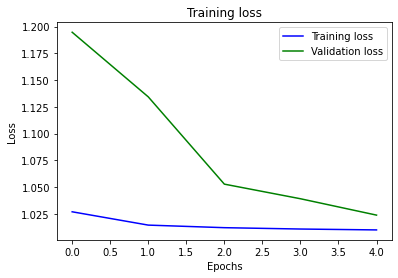

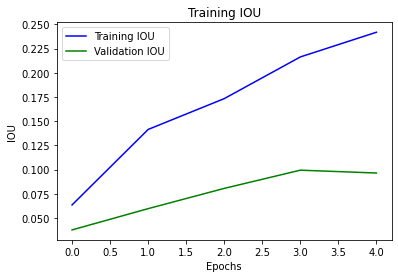

In [ ]:
trainingGraph(history2)

**Testing data**

In [13]:
testing_images, y_masks,testingMasks = testing("/content/drive/MyDrive/A3_Dataset/dataset1/images_prepped_test","/content/drive/MyDrive/A3_Dataset/dataset1/annotations_prepped_test")

**Predicted masks and superimposed results on original image**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  # This is added back by InteractiveShellApp.init_path()


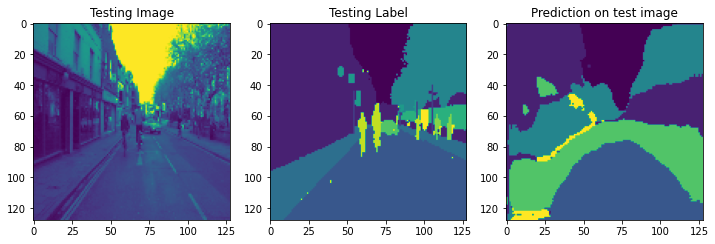

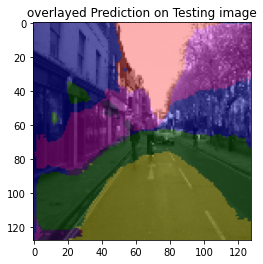

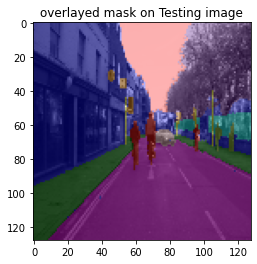

In [ ]:
result1, result2 = correct_Incorrect("resnet50",testing_images, y_masks,testingMasks, 11,model)
overlay(result1, "overlayed Prediction on Testing image")
overlay(result2, "overlayed mask on Testing image")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  # This is added back by InteractiveShellApp.init_path()


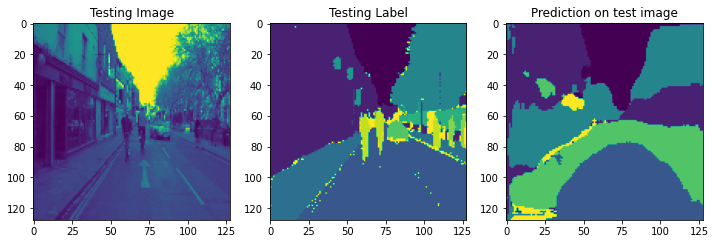

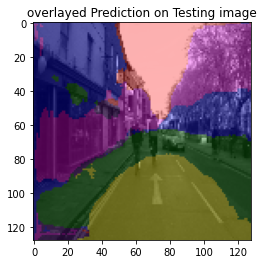

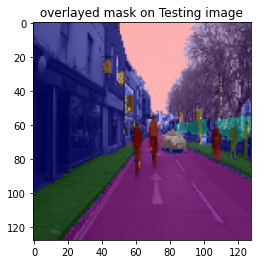

In [ ]:
result1, result2 = correct_Incorrect("resnet50",testing_images, y_masks,testingMasks, 20,model)
overlay(result1, "overlayed Prediction on Testing image")
overlay(result2, "overlayed mask on Testing image")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  # This is added back by InteractiveShellApp.init_path()


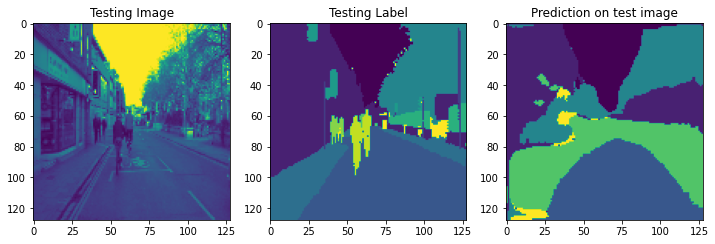

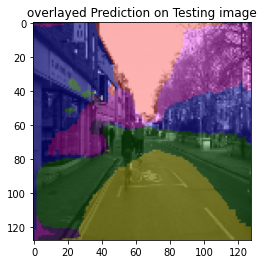

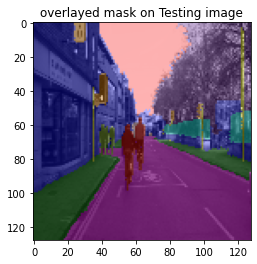

In [ ]:
result1, result2 = correct_Incorrect("resnet50",testing_images, y_masks,testingMasks, 51,model)
overlay(result1, "overlayed Prediction on Testing image")
overlay(result2, "overlayed mask on Testing image")

**Qunatitative Measures**

In [ ]:
testMetrics("resnet50", testing_images, y_masks,model)

average of Dice Coefficient, Sensitivity, Specificity,f1-score, iou accuracy 0.004313260906993753 0.00396728515625 0.009802982358649225 0.004313260906993753 0.002757203755992474
average of Dice Coefficient, Sensitivity, Specificity,f1-score, iou accuracy 0.008593040822756172 0.007944843556621287 0.019620907778787142 0.008593040822756172 0.005487104158590336
average of Dice Coefficient, Sensitivity, Specificity,f1-score, iou accuracy 0.012908629851766152 0.01201727838799505 0.029444656159618113 0.012908629851766152 0.008246210837128138
average of Dice Coefficient, Sensitivity, Specificity,f1-score, iou accuracy 0.017316607555540483 0.016212992148824257 0.039269063732411603 0.01731660785061298 0.011081298093984622
average of Dice Coefficient, Sensitivity, Specificity,f1-score, iou accuracy 0.02166326919404587 0.020308390702351485 0.049103305481448034 0.02166326948911837 0.013865857431204012
average of Dice Coefficient, Sensitivity, Specificity,f1-score, iou accuracy 0.02598944365388096 0

**Unet with Inceptionv3 Backbone**

In [14]:
model, training_imgs,y_masks, trainingMsks = training(trainimgPath,trainmaskPath, "inceptionv3")

87916544/87910968 [==============================] - 4s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
___________________________

**Model Training**

In [ ]:
filepath="inceptionv3.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# defining checkpointing variable
callbacks_list = [checkpoint]
history= model.fit(training_imgs, y_masks,epochs=5, batch_size=32, validation_split=0.2, callbacks=callbacks_list)
#model2.save('res34_backbone_50epochs2.hdf5')
tf.saved_model.save(model, 'saved_model')

Epoch 1/5
19/19 [==============================] - 301s 15s/step - loss: 1.0364 - iou_score: 0.0335 - f1-score: 0.0492 - accuracy: 0.2992 - dice_coef: 0.1778 - val_loss: 1.2308 - val_iou_score: 0.0249 - val_f1-score: 0.0438 - val_accuracy: 0.1235 - val_dice_coef: 0.1166

Epoch 00001: val_accuracy improved from -inf to 0.12353, saving model to vgg16.hdf5
Epoch 2/5
19/19 [==============================] - 289s 15s/step - loss: 1.0147 - iou_score: 0.1554 - f1-score: 0.1952 - accuracy: 0.7044 - dice_coef: 0.4448 - val_loss: 1.1322 - val_iou_score: 0.0282 - val_f1-score: 0.0496 - val_accuracy: 0.1384 - val_dice_coef: 0.1429

Epoch 00002: val_accuracy improved from 0.12353 to 0.13840, saving model to vgg16.hdf5
Epoch 3/5
19/19 [==============================] - 288s 15s/step - loss: 1.0120 - iou_score: 0.1938 - f1-score: 0.2484 - accuracy: 0.7244 - dice_coef: 0.4835 - val_loss: 1.0713 - val_iou_score: 0.0587 - val_f1-score: 0.0923 - val_accuracy: 0.2204 - val_dice_coef: 0.2142

Epoch 00003: 

**Training Graph**

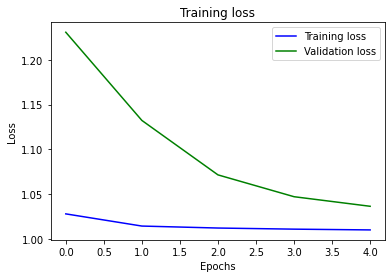

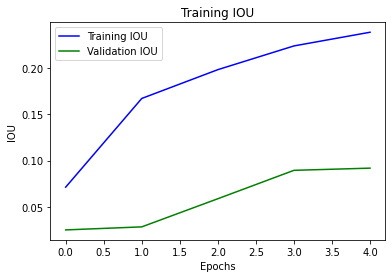

In [ ]:
trainingGraph(history)

**Predicted masks and superimposed results on original image**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  # This is added back by InteractiveShellApp.init_path()


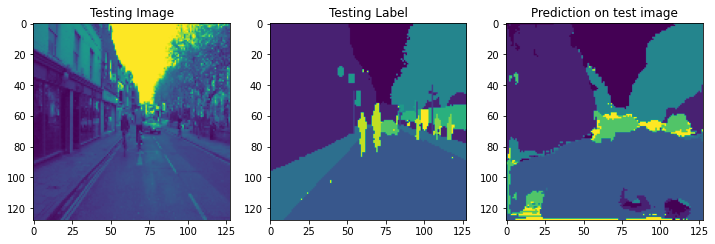

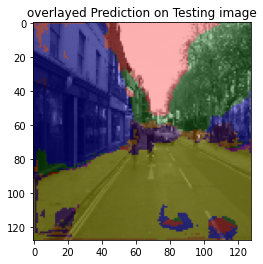

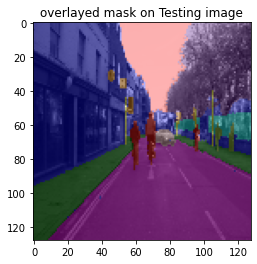

In [ ]:
result1, result2 = correct_Incorrect("resnet50",testing_images, y_masks,testingMasks, 11,model)
overlay(result1, "overlayed Prediction on Testing image")
overlay(result2, "overlayed mask on Testing image")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  # This is added back by InteractiveShellApp.init_path()


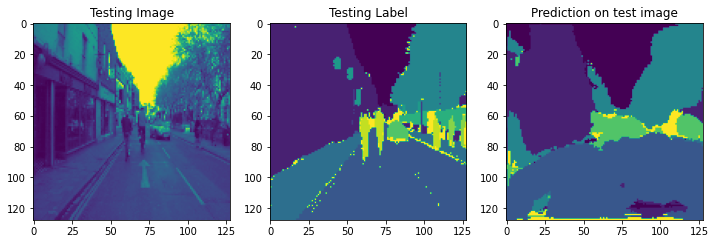

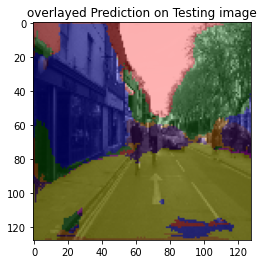

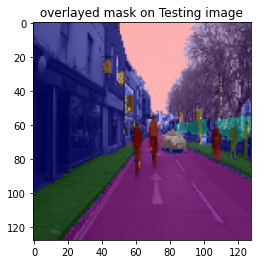

In [ ]:
result1, result2 = correct_Incorrect("resnet50",testing_images, y_masks,testingMasks, 20,model)
overlay(result1, "overlayed Prediction on Testing image")
overlay(result2, "overlayed mask on Testing image")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  # This is added back by InteractiveShellApp.init_path()


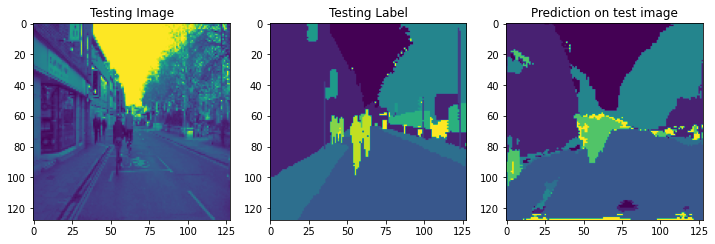

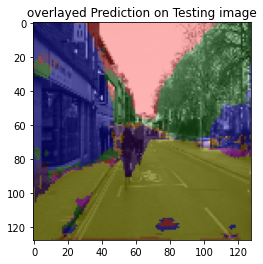

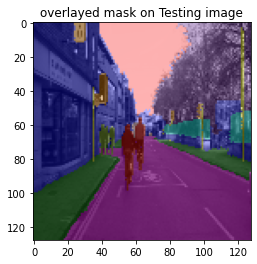

In [ ]:
result1, result2 = correct_Incorrect("resnet50",testing_images, y_masks,testingMasks, 51,model)
overlay(result1, "overlayed Prediction on Testing image")
overlay(result2, "overlayed mask on Testing image")

In [ ]:
testMetrics("inceptionv3", testing_images, y_masks,model)

average of Dice Coefficient, Sensitivity, Specificity,f1-score, iou accuracy 0.002247639811865174 0.002165841584158416 0.00974128801043671 0.002247639811865174 0.0012677127476966026
average of Dice Coefficient, Sensitivity, Specificity,f1-score, iou accuracy 0.004492526892388221 0.0043093237546410895 0.019483180329351143 0.004492526892388221 0.0025336742401123047
average of Dice Coefficient, Sensitivity, Specificity,f1-score, iou accuracy 0.0067224650099726 0.006438906830136139 0.029224962881295988 0.0067224650099726 0.0037901358734263053
average of Dice Coefficient, Sensitivity, Specificity,f1-score, iou accuracy 0.008957456539172938 0.008576345915841584 0.03896663507612625 0.008957456686709187 0.005049807010310711
average of Dice Coefficient, Sensitivity, Specificity,f1-score, iou accuracy 0.011192291237340115 0.010716806543935644 0.04870698888703148 0.011192291532412614 0.006309378560226743
average of Dice Coefficient, Sensitivity, Specificity,f1-score, iou accuracy 0.01343157061255